# Neural Networks

[PyTorch](https://pytorch.org)

`conda install -c pytorch pytorch`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [8, 6]

# Linear regression

In [2]:
import pandas as pd

# Meseares of various features and diabetes disease progression for 442 patients.
# Available at https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt
df = pd.read_csv('diabetes.csv')
df

,AGE,SEX,BMI,BP,TC,LDL,HDL,TCH,LTG,GLU,DIS
0,59,2,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...,...
437,60,2,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
438,47,2,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
439,60,2,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
440,36,1,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


In [97]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()

Xs = (X - X.mean(axis=0)) / X.std(axis=0)
ys = (y - y.mean()) / y.std()

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, shuffle=True, test_size=0.2, random_state=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((353, 10), (353,), (89, 10), (89,))

In [98]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

LR_train_pred = LR_model.predict(X_train)
LR_test_pred = LR_model.predict(X_test)

LR_train_mse = ((y_train - LR_train_pred)**2).mean()
LR_test_mse = ((y_test - LR_test_pred)**2).mean()

LR_train_mse, LR_test_mse

(0.47809312826669104, 0.50466093041034)

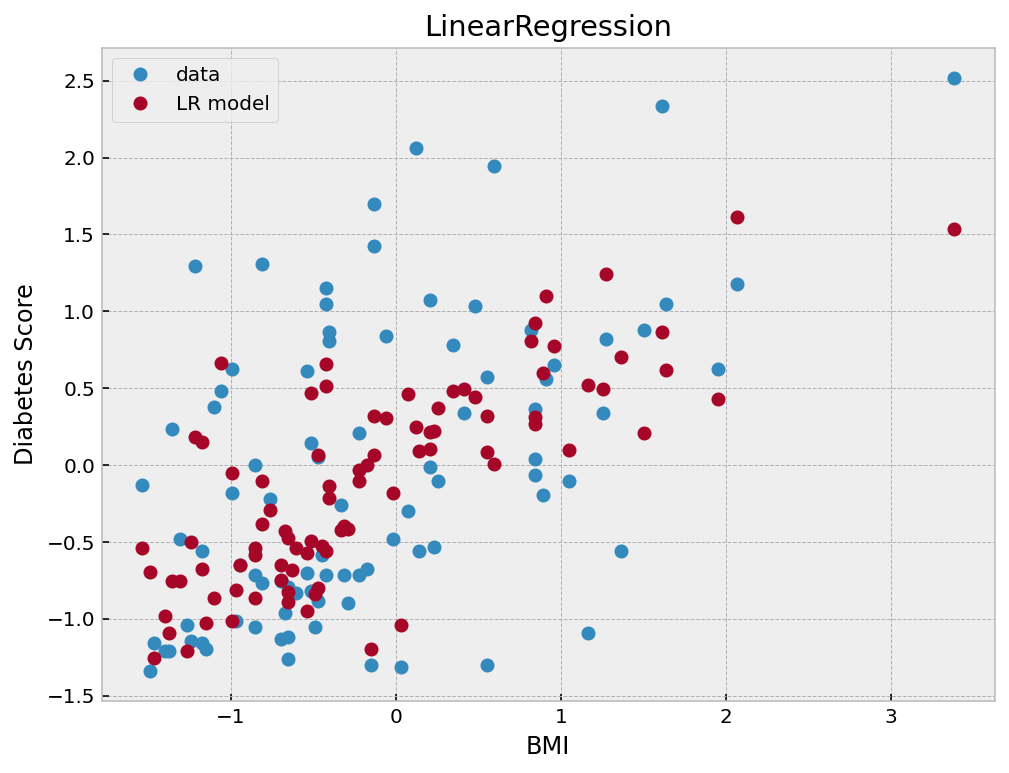

In [99]:
bmi_test = X_test[:,2]

plt.plot(bmi_test, y_test, 'o', label='data')
plt.plot(bmi_test, LR_test_pred, 'o', label='LR model')
plt.xlabel('BMI')
plt.ylabel('Diabetes Score')
plt.title('LinearRegression')
plt.legend();

# Linear regression with PyTorch

In [116]:
import torch

Xt_train = torch.tensor(X_train).float()
yt_train = torch.tensor(y_train.reshape([-1,1])).float()

Xt_test = torch.tensor(X_test).float()
yt_test = torch.tensor(y_test.reshape([-1,1])).float()

Xt_train.shape, yt_train.shape, Xt_test.shape, yt_test.shape

(torch.Size([353, 10]),
 torch.Size([353, 1]),
 torch.Size([89, 10]),
 torch.Size([89, 1]))

In [117]:
from torch import nn

class LinearRegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10, 1)

    def forward(self, x):
        y = self.linear(x)
        return y

In [118]:
torch.manual_seed(1)
NN_LR_model = LinearRegressionNN()

In [119]:
NN_LR_model.linear.weight, NN_LR_model.linear.bias

(Parameter containing:
 tensor([[ 0.1629, -0.1396, -0.0613,  0.1484, -0.2977,  0.1896, -0.0651,  0.1609,
           0.0440, -0.0387]], requires_grad=True),
 Parameter containing:
 tensor([0.0877], requires_grad=True))

In [124]:
# loss function
loss_fn = nn.MSELoss()

# stochastic gradient descent optimizer
# lr = learning rate
optimizer = torch.optim.SGD(NN_LR_model.parameters(), lr=1e-2)

In [125]:
def train(model, X, y, loss_fn, optimizer, n_epochs):
    # put model into training mode
    model.train()
    
    train_loss = np.zeros(n_epochs)
    for i in range(n_epochs):
        # Compute prediction error
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # update model parameters (i.e., weights and biases)
        optimizer.step()
        
        # store loss
        train_loss[i] = loss.item()
    
    return train_loss

In [126]:
torch.manual_seed(1)
NN_LR_train_mse = train(NN_LR_model, Xt_train, yt_train, loss_fn, optimizer, 300)

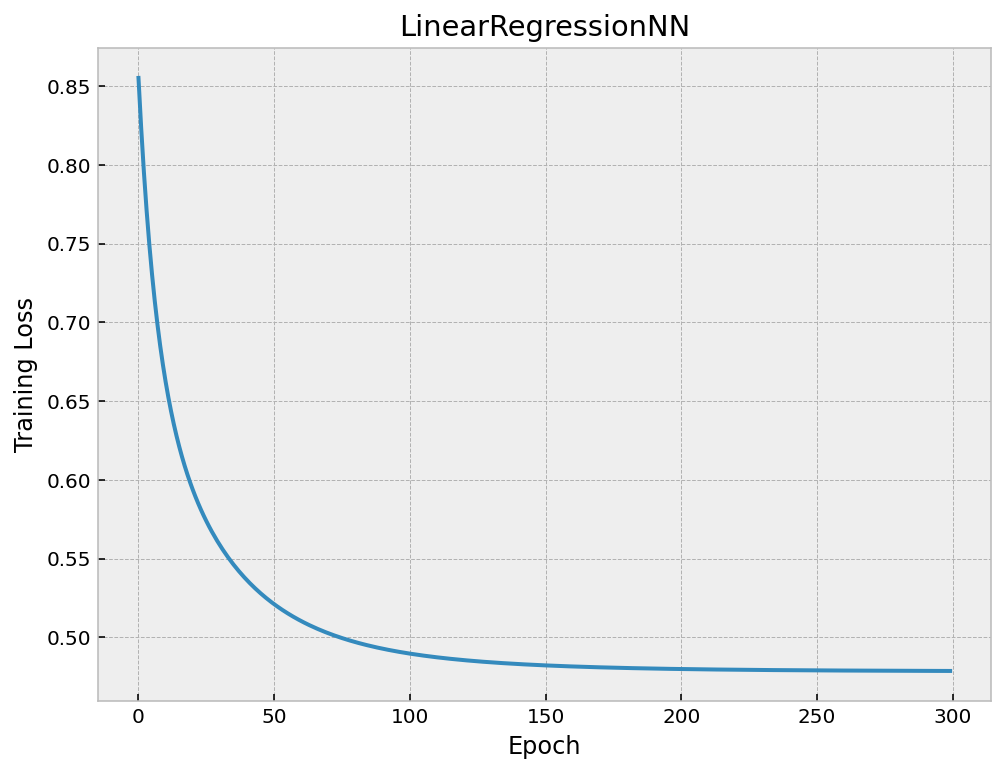

In [127]:
plt.plot(NN_LR_train_mse)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('LinearRegressionNN');

In [128]:
NN_LR_model.linear.weight, NN_LR_model.linear.bias

(Parameter containing:
 tensor([[-0.0146, -0.1776,  0.3212,  0.2112, -0.2602,  0.1070, -0.0451,  0.1198,
           0.3509,  0.0417]], requires_grad=True),
 Parameter containing:
 tensor([-0.0095], requires_grad=True))

In [129]:
def test(model, X, y, loss_fn):
    # put model into testing (evaluation) mode
    model.eval()
    
    with torch.no_grad():
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        test_loss = loss.item()
    
    return test_loss

In [130]:
NN_LR_test_mse = test(NN_LR_model, Xt_test, yt_test, loss_fn)

NN_LR_train_mse[-1], NN_LR_test_mse

(0.47875893115997314, 0.5081381797790527)

In [131]:
LR_train_mse, LR_test_mse

(0.47809312826669104, 0.50466093041034)

In [132]:
NN_LR_test_pred = NN_LR_model(Xt_test)

NN_LR_test_pred.shape

torch.Size([89, 1])

In [133]:
NN_LR_test_pred.squeeze().shape

torch.Size([89])

In [134]:
NN_LR_test_pred.squeeze().numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [135]:
NN_LR_test_pred = NN_LR_test_pred.squeeze().detach().numpy()

NN_LR_test_pred.shape

(89,)

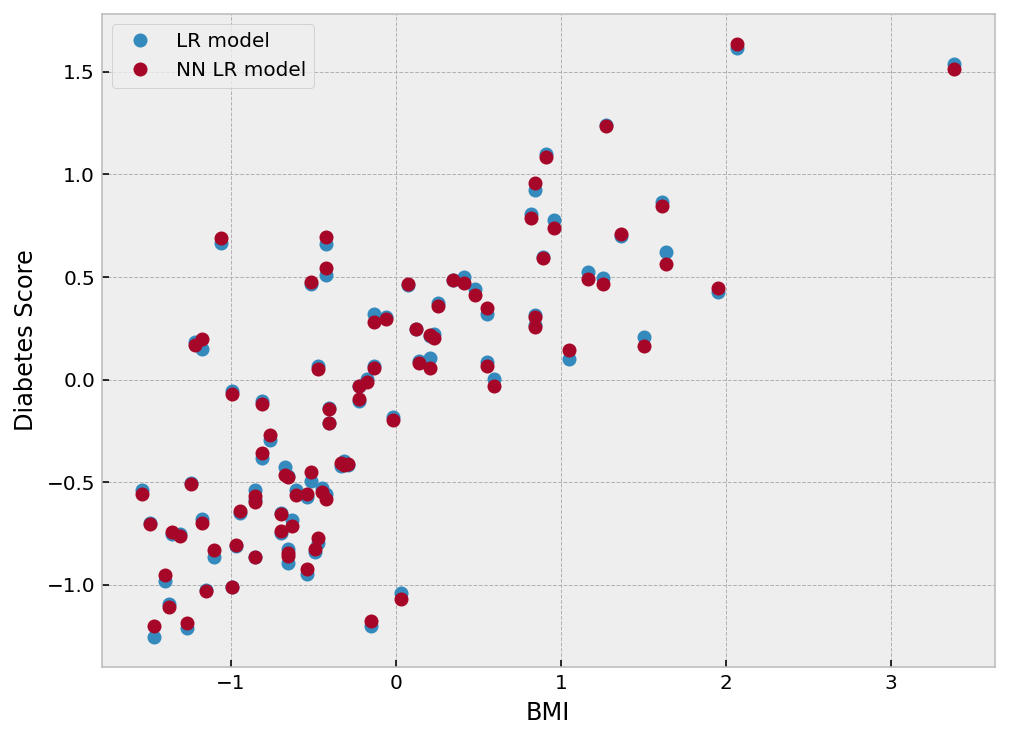

In [136]:
#plt.plot(bmi_test, y_test, 'o', label='data')
plt.plot(bmi_test, LR_test_pred, 'o', label='LR model')
plt.plot(bmi_test, NN_LR_test_pred, 'o', label='NN LR model')
plt.xlabel('BMI')
plt.ylabel('Diabetes Score')
plt.legend();

# L2 Regularization

$loss = loss + \alpha \sum_i w_i^2$

In [266]:
alphas = np.logspace(-2, 0, 20)
test_mse = np.zeros(alphas.shape)
for i, alpha in enumerate(alphas):
    torch.manual_seed(1)
    NN_LR_L2_model = LinearRegressionNN()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(NN_LR_L2_model.parameters(), lr=1e-2, weight_decay=alpha)
    NN_LR_L2_train_mse = train(NN_LR_L2_model, Xt_train, yt_train, loss_fn, optimizer, 300)
    test_mse[i] = test(NN_LR_L2_model, Xt_test, yt_test, loss_fn)
alpha = alphas[np.argmin(test_mse)]
alpha

0.18329807108324356

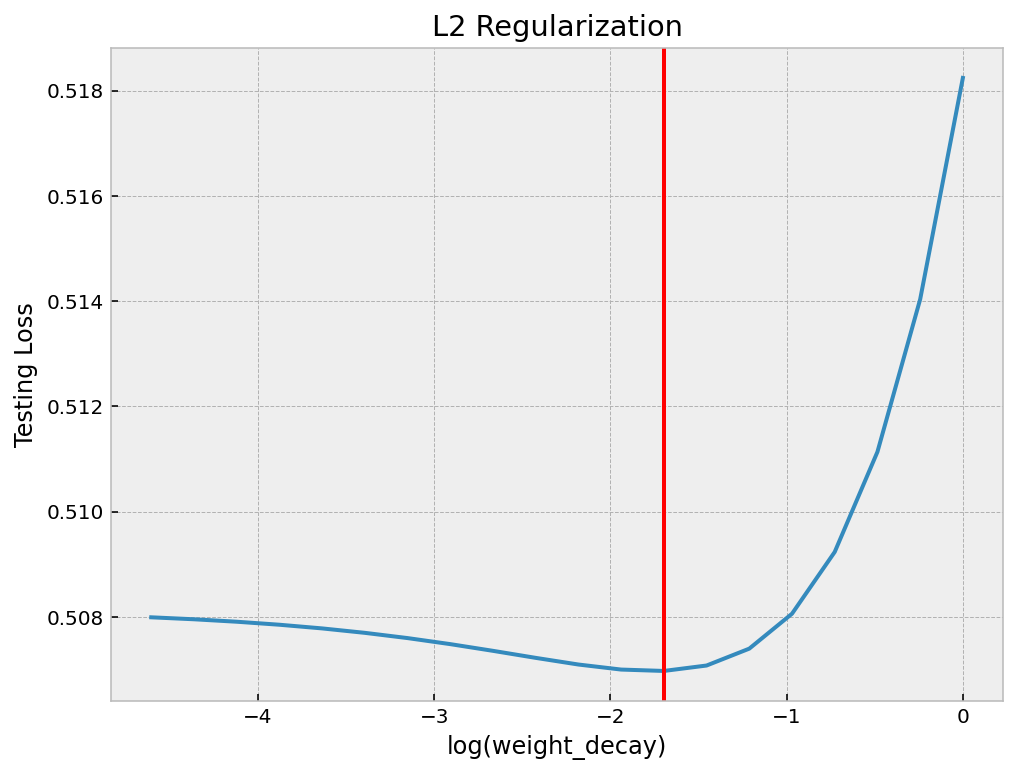

In [267]:
plt.plot(np.log(alphas), test_mse)
plt.axvline(np.log(alpha), color='r')
plt.xlabel('log(weight_decay)')
plt.ylabel('Testing Loss')
plt.title('L2 Regularization');

# Moving from the CPU to the GPU

In [20]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cpu'

Google Colab offers you free online use of GPUs so you can try this out even if you don't have a CUDA compatible NVIDIA GPU.

In [22]:
# create model and move it to the GPU if you have the appropriate hardware
NN_LR_model = LinearRegressionNN().to(device)

CPU and GPU memory don't play together, so if your model exists on the GPU you must also move any data you want it to work with to the GPU as well.

In [23]:
Xt_train = Xt_train.to(device)
yt_train = yt_train.to(device)

Xt_test = Xt_test.to(device)
yt_test = yt_test.to(device)

# Mouse V1 activity in response to gratings of varying orientation

Mouse V1 data from Stringer et al. (2019)
https://www.biorxiv.org/content/10.1101/679324v2.abstract

![](images/grating-mouse.png)

These data comprise time-averaged responses of ~20,000 neurons to ~4,000 stimulus gratings of different orientations from 0-360 degrees, recorded through Calcium imaging. The responses have been normalized by spontaneous levels of activity and then z-scored over stimuli, so expect negative numbers. They have also been binned and averaged to each degree of orientation.

Example from [Neuromatch Academy](https://compneuro.neuromatch.io/tutorials/W2D1_DeepLearning/student/W2D1_Tutorial1.html)

Grating orientations

![](images/grating-orientations.png)

In [274]:
neural_responses = np.load('neural_responses.npy')
grating_orientations = np.load('grating_orientations.npy')

neural_responses.shape, grating_orientations.shape

((360, 23589), (360,))

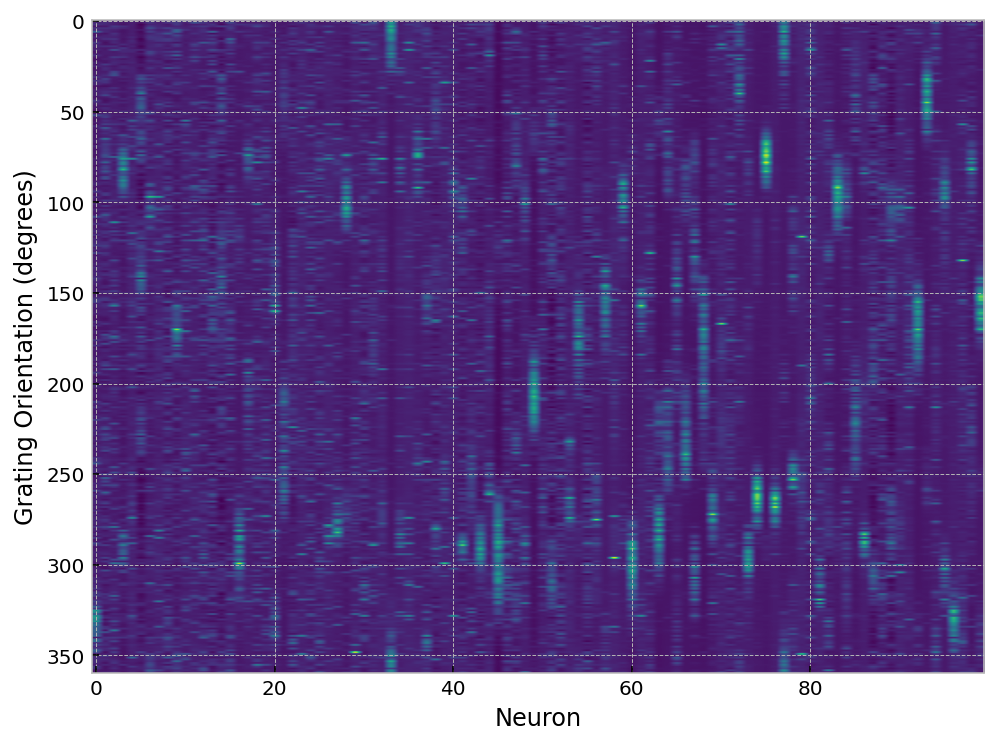

In [275]:
plt.imshow(neural_responses[:,:100], aspect='auto')
plt.xlabel('Neuron')
plt.ylabel('Grating Orientation (degrees)');

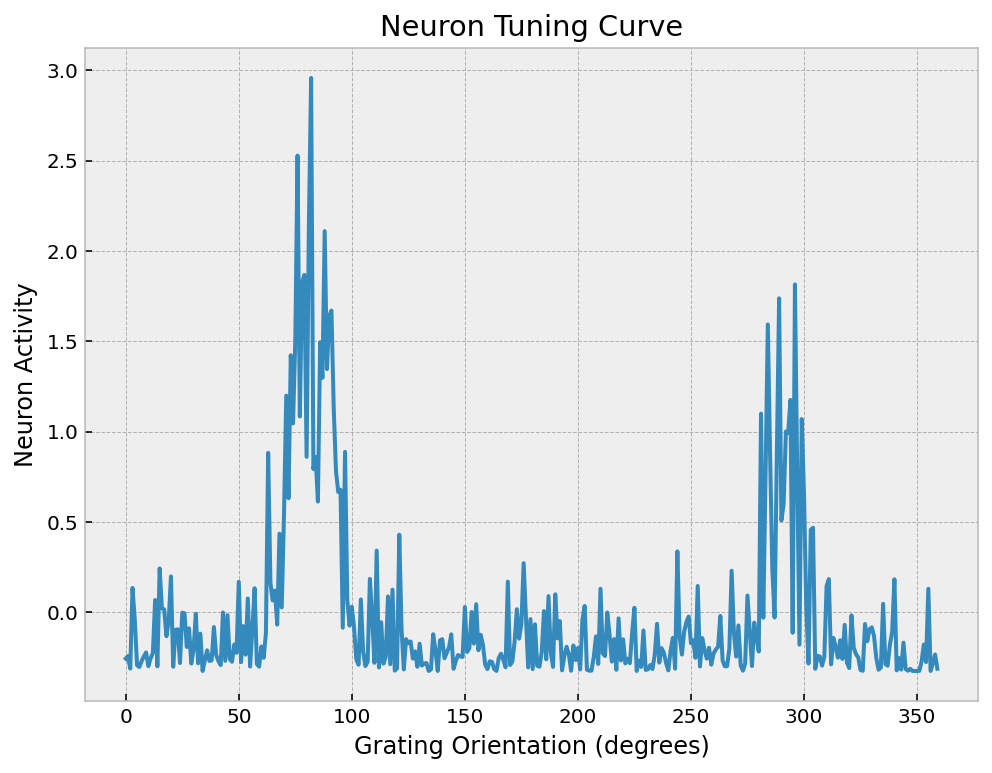

In [276]:
plt.plot(grating_orientations, neural_responses[:,3])
plt.xlabel('Grating Orientation (degrees)')
plt.ylabel('Neuron Activity')
plt.title('Neuron Tuning Curve');

In [277]:
from sklearn.model_selection import train_test_split

X = neural_responses
y = grating_orientations

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.4, random_state=3)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((216, 23589), (216,), (144, 23589), (144,))

In [278]:
Xt = torch.tensor(X).float().to(device)
yt = torch.tensor(y.reshape([-1,1])).float().to(device)

Xt_train = torch.tensor(X_train).float().to(device)
yt_train = torch.tensor(y_train.reshape([-1,1])).float().to(device)

Xt_test = torch.tensor(X_test).float().to(device)
yt_test = torch.tensor(y_test.reshape([-1,1])).float().to(device)

Xt_train.shape, yt_train.shape, Xt_test.shape, yt_test.shape

(torch.Size([216, 23589]),
 torch.Size([216, 1]),
 torch.Size([144, 23589]),
 torch.Size([144, 1]))

In [279]:
class GratingOrientationNet(nn.Module):
    def __init__(self, n_inputs, n_hidden):
        super().__init__()
        self.hidden_layer = nn.Linear(n_inputs, n_hidden)
        self.output_layer = nn.Linear(n_hidden, 1)

    def forward(self, x):
        h = torch.relu(self.hidden_layer(x))
        y = self.output_layer(h)
        return y

In [280]:
torch.manual_seed(1)
grating_model = GratingOrientationNet(23589, 10)

In [281]:
# predicted orientation for neural responses associated with gratings at 36 degrees
pred_orientation = grating_model(Xt[36,:])
pred_orientation

tensor([0.1067], grad_fn=<AddBackward0>)

In [282]:
# predicted orientation for neural responses associated with gratings at 90 degrees
pred_orientation = model(Xt[90,:])
pred_orientation

tensor([0.3016], grad_fn=<AddBackward0>)

In [283]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(grating_model.parameters(), lr=1e-4)

train_loss = train(grating_model, Xt_train, yt_train, loss_fn, optimizer, 50)

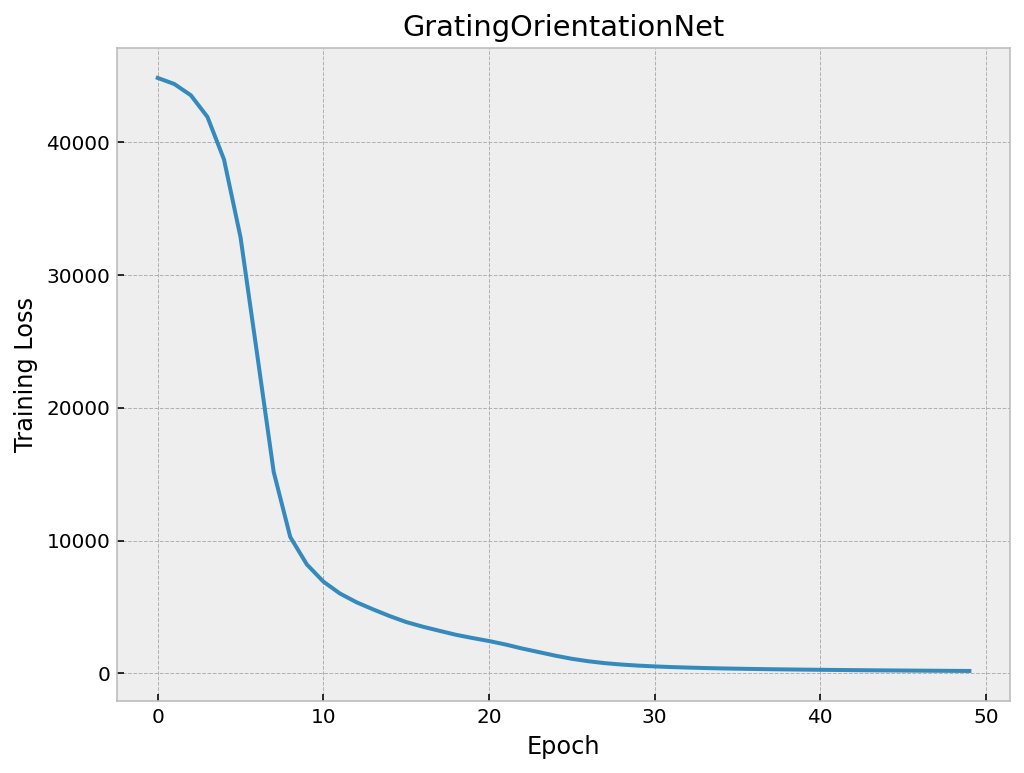

In [284]:
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('GratingOrientationNet');

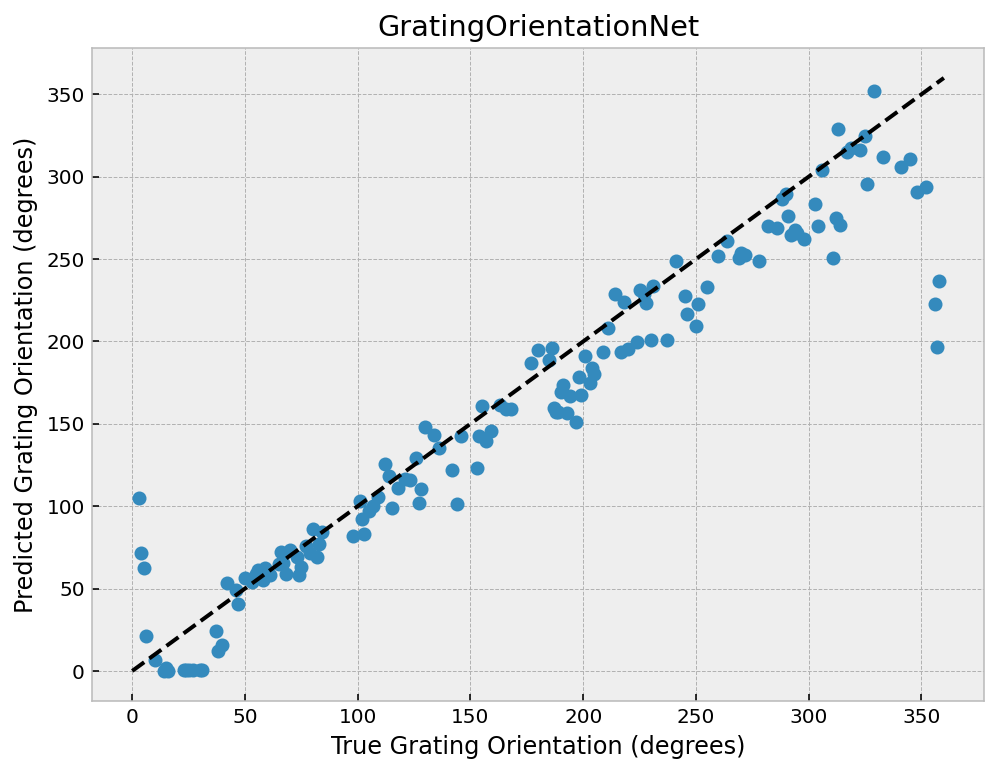

In [287]:
pred = grating_model(Xt_test)

pred_grating_orientations = pred.squeeze().detach().numpy()

plt.plot(y_test, pred_grating_orientations, 'o')
plt.plot([0, 360], [0, 360], 'k--')
plt.xlabel('True Grating Orientation (degrees)')
plt.ylabel('Predicted Grating Orientation (degrees)')
plt.title('GratingOrientationNet');